# Capacities and potentials

This example notebook shows how voltage cut-offs and initial lithium concentrations impact the capacities and potentials of the cell. Also, different input options are shown; (1) how to input stoichiometry limits instead of voltage cut-offs and (2) how to input average potentials and gravimetric active material capacities instead of potential curves and concentrations.

The simplist way to create a TEA class is to start with a PyBaMM parameter-set and add/update values with an input parameter-set. A good overview of variables about capacities and potentials can be found in the capacities and potentials dataframe.

In [8]:
import pybamm
from pybamm_tea import tea
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# input parameter-set
input = {
    # add electrolyte density
    "Electrolyte density [kg.m-3]": 1276
}

# base parameter-sets
base = pybamm.ParameterValues("Chen2020")

# create a TEA class
tea_class = tea.TEA(base, input)

# get the stack energy
display(tea_class.stack_energy_dataframe)

# get the mass and volume loadings as a dataframe
tea_class.capacities_and_potentials_dataframe

,Parameter,Unit,Value
0,Volumetric stack energy,W.h.L-1,997.596702
1,Gravimetric stack energy,W.h.kg-1,398.264666
2,Areal stack energy,W.h.m-2,186.351064
3,Stack average OCP,V,3.713903
4,Capacity,mA.h.cm-2,5.017660
5,Stack thickness,um,186.800000
6,Stack density,kg.L-1,2.504859


,Parameter,Unit,Value
0,Stack average OCP,V,3.713903
1,Minimal OCP,V,2.500043
2,Maximal OCP,V,4.199987
3,Negative electrode average OCP,V,0.193702
4,Positive electrode average OCP,V,3.907606
5,Practical n/p ratio,-,1.101087
6,Theoretical n/p ratio,-,0.667362
7,Volumetric stack capacity,A.h.L-1,268.611371
8,Gravimetric stack capacity,A.h.kg-1,107.236138
9,Capacity,mA.h.cm-2,5.017660


### What can be seen in the dataframe?

The dataframe shows the the stack average OCP at the top. The stack average OCP is calculated as the difference between the positive electrode average OCP and the negative electrode average OCP. The minimal and maximal voltages of the stack OCP are limited by the voltage cut-offs, to which the stoichiometries at 0% and 100% SoC refer (here, the stoichiometry means the degree of lithiation, not the ratio of atoms).

Below, the OCP's of the active materials are plotted against the stoichiometry and together with the stack OCP against the SoC.

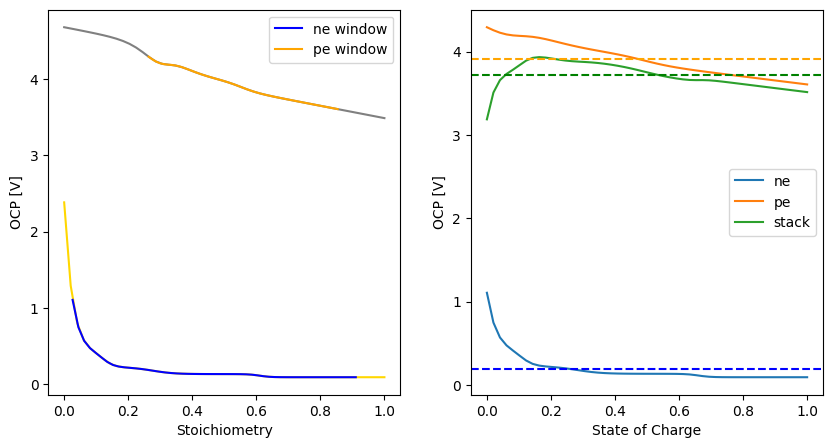

In [10]:
# get the OCP functions
U_n = tea_class.parameter_values.get("Negative electrode OCP [V]")
U_p = tea_class.parameter_values.get("Positive electrode OCP [V]")

# get the stoichiometries at 0% and 100% SoC
x0 = tea_class.stack_energy.get("Negative electrode stoichiometry at 0% SoC")
x100 = tea_class.stack_energy.get("Negative electrode stoichiometry at 100% SoC")
y0 = tea_class.stack_energy.get("Positive electrode stoichiometry at 0% SoC")
y100 = tea_class.stack_energy.get("Positive electrode stoichiometry at 100% SoC")

# create vectors of stoichiometries
soc = pybamm.linspace(0, 1)
x = x0 + (x100 - x0) * soc
y = y100 + (y0 - y100) * soc

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot the positive and negative active material OCP's and the utilised OCP vs. the stoichiometry
axs[0].plot(soc.entries, U_n(soc).entries, color="gold")
axs[0].plot(x.entries, U_n(x).entries, color="blue", label="ne window")
axs[0].plot(soc.entries, U_p(soc).entries, color="gray")
axs[0].plot(y.entries, U_p(y).entries, color="orange", label="pe window")
axs[0].set_xlabel("Stoichiometry")
axs[0].set_ylabel("OCP [V]")
axs[0].legend()

# plot the positive and negative utilised OCP's vs. the state of charge
axs[1].plot(soc.entries, U_n(x).entries, label="ne")
axs[1].plot(soc.entries, U_p(y).entries, label="pe")
axs[1].plot(soc.entries, U_p(y).entries - U_n(x).entries, label='stack')
axs[1].set_xlabel("State of Charge")
axs[1].set_ylabel("OCP [V]")
axs[1].legend()

# add horizontal lines with mean OCP's
axs[1].axhline(U_n(x).entries.mean(), color="blue", linestyle="--")
axs[1].axhline(U_p(y).entries.mean(), color="orange", linestyle="--")
axs[1].axhline((U_p(y).entries - U_n(x).entries).mean(), color="green", linestyle="--")

plt.show()

### n/p ratio's and voltage cut-off's

When limiting the upper voltage cut-off, the practical n/p ratio changes according to the changing stoichiometry limits at 100% and 0% SoC. The theoretical n/p ratio considers the theoretical maximal lithium concentrations in the active materials and the active material volume fraction and thickness. The practical n/p ratio refers to ratio of the concentration from a stoichiometry range between 100% lithiation and the stoichiometry at 0% SoC for the negative electrode and between 0% and 100% SoC for the positive electrode, as below.

\begin{equation*}
\begin{aligned}
& n / p_{\text {theoretical }}=\frac{C_{\text {max }}^{-} v_{\text {active }}^{-} t^{-}}{C_{\max }^{+} v_{\text {active }}^{+} t^{+}} \\
& n / p_{\text {practical }}=\frac{(1-x 0)}{(y 0-y 100)} n / p_{\text {theoretical }}
\end{aligned}
\end{equation*}

Let's see how gravimetric and volumetric stack energy, the practical n/p ratio and the stoichiometries at 0% and 100% change with upper voltage cut-off.

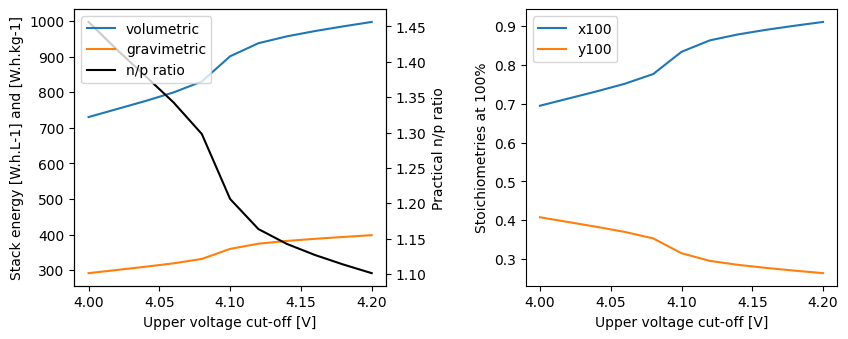

In [11]:
# generate an array of upper voltage cut-offs to loop over
upper_cut_off_potentials = np.linspace(4, 4.2, 11)

# initialize lists for the stack energy densities
stack_volumetric_energy = []
stack_gravimetric_energy = []
n_p_ratios = []
x100s = []
y100s = []

# loop over the potentials and calculate the stack energy densities
for potential in upper_cut_off_potentials:
    # update the upper voltage cut-off in the input
    input.update({"Upper voltage cut-off [V]": potential})
    
    # create a TEA classes with the updated input
    tea_class = tea.TEA(base, input)

    # save the calculated the stack energy densities in the lists
    stack_volumetric_energy.append(tea_class.stack_energy.get("Volumetric stack energy [W.h.L-1]"))
    stack_gravimetric_energy.append(tea_class.stack_energy.get("Gravimetric stack energy [W.h.kg-1]"))
    n_p_ratios.append(tea_class.stack_energy.get("Practical n/p ratio"))
    
    x100s.append(tea_class.stack_energy.get("Negative electrode stoichiometry at 100% SoC"))
    y100s.append(tea_class.stack_energy.get("Positive electrode stoichiometry at 100% SoC"))

# set up the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=7.0)

# plot stack energy and n/p ratio vs. the upper voltage cut-off
axs[0].plot(upper_cut_off_potentials, stack_volumetric_energy, label="volumetric")
axs[0].plot(upper_cut_off_potentials, stack_gravimetric_energy, label="gravimetric")
axs[0].set_xlabel("Upper voltage cut-off [V]")
axs[0].set_ylabel("Stack energy [W.h.L-1] and [W.h.kg-1]")
ax_ = axs[0].twinx()
ax_.plot(upper_cut_off_potentials, n_p_ratios, color="black", label="n/p ratio")
ax_.set_ylabel("Practical n/p ratio", color="black")
ax_.tick_params(axis='y', labelcolor="black")
lines, labels = axs[0].get_legend_handles_labels()
lines2, labels2 = ax_.get_legend_handles_labels()
ax_.legend(lines + lines2, labels + labels2, loc='upper left')

# plot the stoichiometries vs the upper voltage cut-off
axs[1].plot(upper_cut_off_potentials, x100s, label="x100")
axs[1].plot(upper_cut_off_potentials, y100s, label="y100")
axs[1].set_xlabel("Upper voltage cut-off [V]")
axs[1].set_ylabel("Stoichiometries at 100%")
axs[1].legend()

plt.show()

### Setting stoichiometry limits

Instead of limiting the stoichiometric window over the voltage cut-off's, also stoichiometric limits can be set for one electrode. That is useful for setting target capacities or to balance the electrode capacities in case no potential curves are supplied.

In [12]:
input_new = {
    # set the stoichiometries at 0% and 100% SoC
    "Positive electrode stoichiometry at 0% SoC": tea_class.stack_energy.get("Positive electrode stoichiometry at 0% SoC"),
    "Positive electrode stoichiometry at 100% SoC": tea_class.stack_energy.get("Positive electrode stoichiometry at 100% SoC"),
    
    # add electrolyte density
    "Electrolyte density [kg.m-3]": 1276,
}

### Setting average potentials and capacities - lithium metal

Let's see how that works by combining the positive electrode with planar, excess-free, metallic lithium as the negative electrode. That is a bit of a special case, as the thickness is zero in the discharged case. For now, there are two ways to include the negative electrode to a TEA class:

* Zero thickness, but unrealistic high values for e.g. "Negative electrode volumetric capacity" by setting the capacity/concentration to a very high value
* Realistic values for e.g. "Negative electrode volumetric capacity", but a higher thickness by setting the capacity/concentration to the actual value

The thickness is calculated based on the theoretical n/p ratio with respect the theoretical maximum in the positive electrode.

In [13]:
input_lithium_discharged = {

    # initialize the concentration in the negative electrode
    "Initial concentration in negative electrode [mol.m-3]": None,
    "Initial concentration in positive electrode [mol.m-3]": None,

    # set electrode thickness
    "Theoretical n/p ratio": 1,
    "Negative electrode thickness [m]": None,

    # set the masses and volumes
    "Negative electrode porosity": 0.2,
    "Negative electrode active material volume fraction": 0.8,
    "Negative electrode density [kg.m-3]": 534, # density of lithium
    "Negative electrode thickness [m]": None,

    # set the potential
    "Negative electrode average OCP [V]": 0, # no overpotential
    "Negative electrode OCP [V]": None,
    # "Stack average OCP [V]": 4, # average cell voltage could also be set for the energy densities

    # set the capacity
    "Negative electrode active material capacity [A.h.kg-1]": 1e100
}

input_lithium_charged = {

    "Negative electrode active material capacity [A.h.kg-1]": 96485 / 3.6 / 6.941, # F [Q.mol-1] / 3600 [Q.Ah] / M_n [g.mol-1] * 1000 [g.kg-1]
    # "Maximum concentration in negative electrode [mol.m-3]": 534 / 6.941 / 1000 maximum concentration of lithium in active material could be set, too
}

# update the input with the new parameters
input_lithium_discharged.update(input_new)
input_lithium_charged = {**input_lithium_discharged, **input_lithium_charged}

# base parameter-sets
base = pybamm.ParameterValues("Chen2020")

# create a TEA class
tea_class_lithium_charged = tea.TEA(base, input_lithium_charged)
tea_class_lithium_discharged = tea.TEA(base, input_lithium_discharged)

# merge dataframes
stack_energies = pd.merge(tea_class.stack_energy_dataframe, tea_class_lithium_charged.stack_energy_dataframe, on=['Parameter', 'Unit'])
stack_energies = pd.merge(stack_energies, tea_class_lithium_discharged.stack_energy_dataframe, on=['Parameter', 'Unit'])
stack_energies = stack_energies.rename(columns={"Value_x": "Gr-Si||NMC811", "Value_y": "Li||NMC811 Charged", "Value": "Li||NMC811 Discharged"})
capacities_and_potentials = pd.merge(tea_class.capacities_and_potentials_dataframe, tea_class_lithium_charged.capacities_and_potentials_dataframe, on=['Parameter', 'Unit'])
capacities_and_potentials = pd.merge(capacities_and_potentials, tea_class_lithium_discharged.capacities_and_potentials_dataframe, on=['Parameter', 'Unit'])
capacities_and_potentials = capacities_and_potentials.rename(columns={"Value_x": "Gr-Si||NMC811", "Value_y": "Li||NMC811 Charged", "Value": "Li||NMC811 Discharged"})

# display the dataframes
display(stack_energies)
display(capacities_and_potentials)

,Parameter,Unit,Gr-Si||NMC811,Li||NMC811 Charged,Li||NMC811 Discharged
0,Volumetric stack energy,W.h.L-1,997.596702,978.747552,1929.826565
1,Gravimetric stack energy,W.h.kg-1,398.264666,516.720031,600.096896
2,Areal stack energy,W.h.m-2,186.351064,196.070379,196.070379
3,Stack average OCP,V,3.713903,3.907606,3.907606
4,Capacity,mA.h.cm-2,5.017660,5.017660,5.017660
5,Stack thickness,um,186.800000,200.327836,101.600000
6,Stack density,kg.L-1,2.504859,1.894154,3.215858


,Parameter,Unit,Gr-Si||NMC811,Li||NMC811 Charged,Li||NMC811 Discharged
0,Stack average OCP,V,3.713903,3.907606,3.907606e+00
1,Minimal OCP,V,2.500043,3.605437,3.605437e+00
2,Maximal OCP,V,4.199987,4.292007,4.292007e+00
3,Negative electrode average OCP,V,0.193702,0.000000,0.000000e+00
4,Positive electrode average OCP,V,3.907606,3.907606,3.907606e+00
5,Practical n/p ratio,-,1.101087,1.447108,1.447108e+00
6,Theoretical n/p ratio,-,0.667362,1.000000,1.000000e+00
7,Volumetric stack capacity,A.h.L-1,268.611371,250.472451,4.938642e+02
8,Gravimetric stack capacity,A.h.kg-1,107.236138,132.234438,1.535715e+02
9,Capacity,mA.h.cm-2,5.017660,5.017660,5.017660e+00


### Loss of lithium inventory

A difference between the above tea classes is the "Initial lithium inventory / positive electrode theoretical capacity" ratio. In the lithium classes, the value is one according to the performed initialization with the positive active material maximum concentration. In the first class it is about 87% according to initial concentrations with a theoretical loss of lithium inventory (LLI) about 13%. The initial lithium inventory is calculated from the initial concentrations as:

\begin{equation*}
n_{\text {Li,initial }}=t^{+} v_{\text {active }}^{+} C_{\text {initial }}^{-}+t^{+} v_{\text {active }}^{+} C_{\text {initial }}^{+}
\end{equation*}

Let's go back to the first class and see the influence of initial concentrations by looping over different initial losses of lithium inventories.

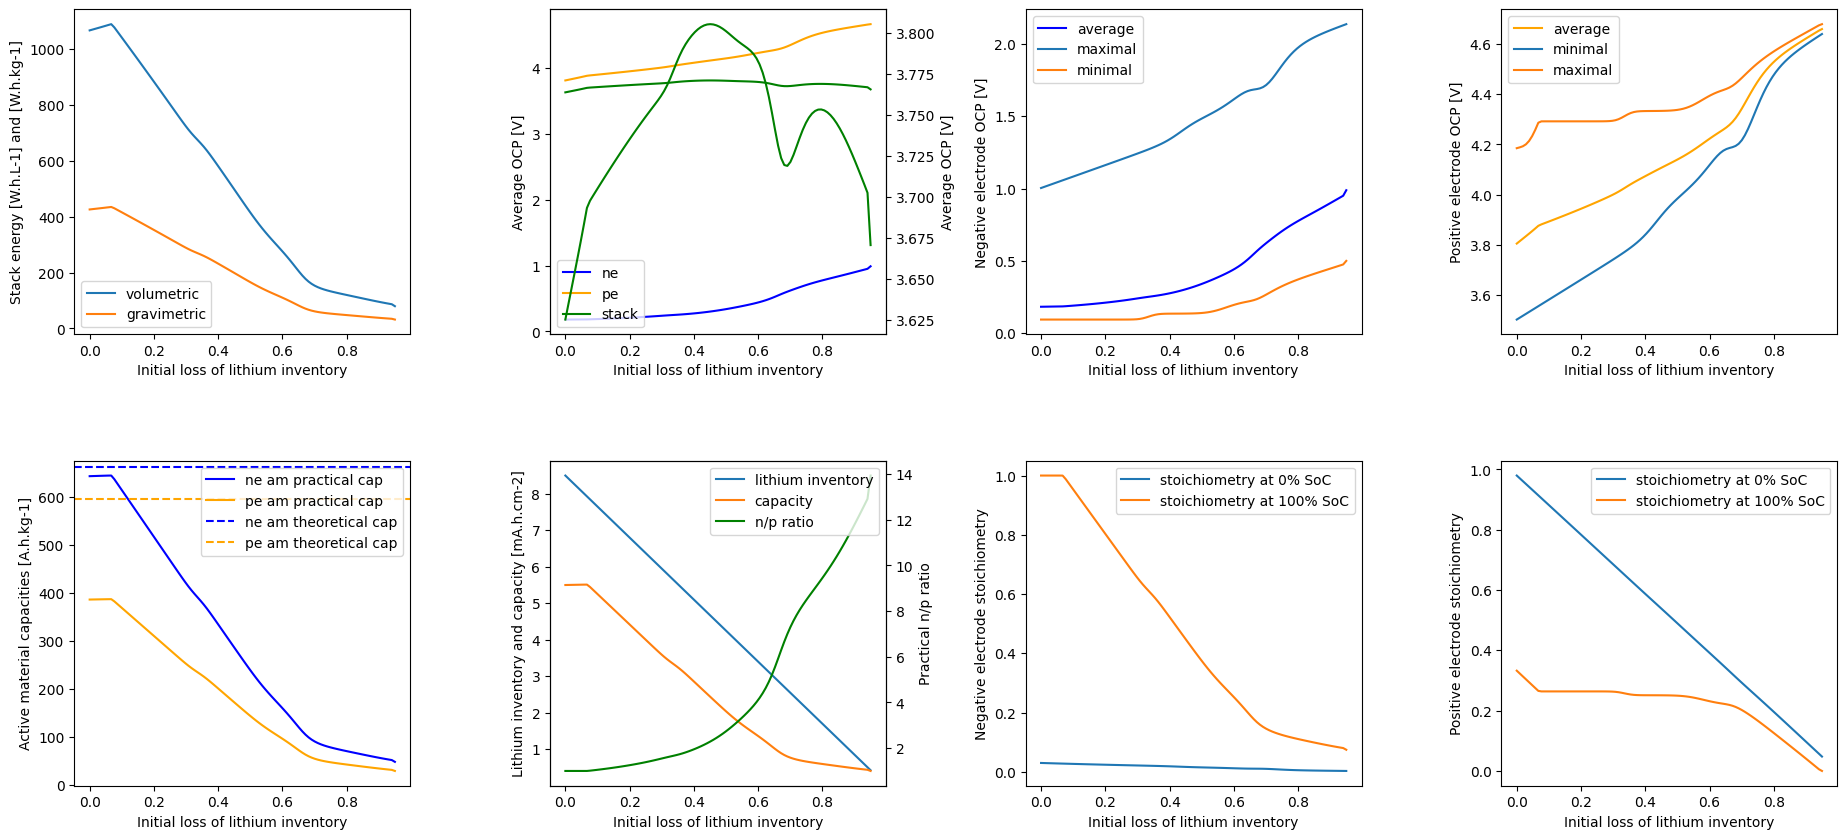

In [14]:
# initialize the active material concentrations to the zero in the negative electrode and to the maximum in the positive electrode
input["Initial concentration in negative electrode [mol.m-3]"] = None
input["Initial concentration in positive electrode [mol.m-3]"] = None

# generate an array of thicknesses from 10e-6 to 100e-6
initial_LLIs = np.linspace(0, 0.95, 100)

# initialize lists with energy densities and electrochemical data
stack_volumetric_energy = []
stack_gravimetric_energy = []
practical_n_p_ratios = []
lithium_inventories = []
capacities = []
stack_average_ocps = []
ne_average_ocp = []
pe_average_ocp = []
ne_stoichiometry_at_0_soc = []
ne_stoichiometry_at_100_soc = []
pe_stoichiometry_at_0_soc = []
pe_stoichiometry_at_100_soc = []
ne_practical_cap_am = []
pe_practical_cap_am = []

# loop over the initial LLI and save values
for initial_LLI in initial_LLIs:
    # update the upper voltage cut-off in the input
    input.update({"Initial loss of lithium inventory": initial_LLI})
    
    # create a TEA classes with the updated input
    tea_class = tea.TEA(base, input)

    # save values in lists
    stack_volumetric_energy.append(tea_class.stack_energy.get("Volumetric stack energy [W.h.L-1]"))
    stack_gravimetric_energy.append(tea_class.stack_energy.get("Gravimetric stack energy [W.h.kg-1]"))
    practical_n_p_ratios.append(tea_class.stack_energy.get("Practical n/p ratio"))
    lithium_inventories.append(tea_class.stack_energy.get("Lithium inventory [mA.h.cm-2]"))
    capacities.append(tea_class.stack_energy.get("Capacity [mA.h.cm-2]"))
    stack_average_ocps.append(tea_class.stack_energy.get("Stack average OCP [V]"))
    ne_average_ocp.append(tea_class.stack_energy.get("Negative electrode average OCP [V]"))
    pe_average_ocp.append(tea_class.stack_energy.get("Positive electrode average OCP [V]"))
    ne_stoichiometry_at_0_soc.append(tea_class.stack_energy.get("Negative electrode stoichiometry at 0% SoC"))
    ne_stoichiometry_at_100_soc.append(tea_class.stack_energy.get("Negative electrode stoichiometry at 100% SoC"))
    pe_stoichiometry_at_0_soc.append(tea_class.stack_energy.get("Positive electrode stoichiometry at 0% SoC"))
    pe_stoichiometry_at_100_soc.append(tea_class.stack_energy.get("Positive electrode stoichiometry at 100% SoC"))
    ne_practical_cap_am.append(tea_class.stack_energy.get("Negative electrode active material practical capacity [A.h.kg-1]"))
    pe_practical_cap_am.append(tea_class.stack_energy.get("Positive electrode active material practical capacity [A.h.kg-1]"))

# create the figure and axes
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# add some padding between the subplots
fig.tight_layout(pad=7.0)

# plot the practical and theoretical active material capacities of the active materials
ne_theoretical_cap_am = tea_class.stack_energy.get("Negative electrode active material capacity [A.h.kg-1]")
pe_theoretical_cap_am = tea_class.stack_energy.get("Positive electrode active material capacity [A.h.kg-1]")
axs[1, 0].plot(initial_LLIs, ne_practical_cap_am, label="ne am practical cap", color="blue")
axs[1, 0].plot(initial_LLIs, pe_practical_cap_am, label="pe am practical cap", color="orange")
axs[1, 0].axhline(y=ne_theoretical_cap_am, label="ne am theoretical cap", color="blue", linestyle='dashed')
axs[1, 0].axhline(y=pe_theoretical_cap_am, label="pe am theoretical cap", color="orange", linestyle='dashed')
axs[1, 0].set_xlabel("Initial loss of lithium inventory")
axs[1, 0].set_ylabel("Active material capacities [A.h.kg-1]")
axs[1, 0].legend()

# plot the lithium inventory and capacity on the left y-axis and the n/p ratio on the right y-axis
axs[1, 1].plot(initial_LLIs, lithium_inventories, label="lithium inventory")
axs[1, 1].plot(initial_LLIs, capacities, label="capacity")
axs[1, 1].set_xlabel("Initial loss of lithium inventory")
axs[1, 1].set_ylabel("Lithium inventory and capacity [mA.h.cm-2]")
# create a second y-axis for the stack average OCP
ax_1_1 = axs[1, 1].twinx()
ax_1_1.plot(initial_LLIs, practical_n_p_ratios, label="n/p ratio", color="green")
ax_1_1.set_ylabel("Practical n/p ratio", color="black")
ax_1_1.tick_params(axis='y', labelcolor="black")
# create a combined legend for the two axes
lines_1_1_1, labels_1_1_1 = axs[1, 1].get_legend_handles_labels()
lines_1_1_2, labels_1_1_2 = ax_1_1.get_legend_handles_labels()
ax_1_1.legend(lines_1_1_1 + lines_1_1_2, labels_1_1_1 + labels_1_1_2, loc='upper right')

# plot the stoichiometries of the negative electrode
axs[1, 2].plot(initial_LLIs, ne_stoichiometry_at_0_soc, label="stoichiometry at 0% SoC")
axs[1, 2].plot(initial_LLIs, ne_stoichiometry_at_100_soc, label="stoichiometry at 100% SoC")
axs[1, 2].set_xlabel("Initial loss of lithium inventory")
axs[1, 2].set_ylabel("Negative electrode stoichiometry")
axs[1, 2].legend()

# plot the stoichiometries of the positive electrode
axs[1, 3].plot(initial_LLIs, pe_stoichiometry_at_0_soc, label="stoichiometry at 0% SoC")
axs[1, 3].plot(initial_LLIs, pe_stoichiometry_at_100_soc, label="stoichiometry at 100% SoC")
axs[1, 3].set_xlabel("Initial loss of lithium inventory")
axs[1, 3].set_ylabel("Positive electrode stoichiometry")
axs[1, 3].legend()

# plot the stack energy densities on the left y-axis and the n/p ratio on the right y-axis
axs[0, 0].plot(initial_LLIs, stack_volumetric_energy, label="volumetric")
axs[0, 0].plot(initial_LLIs, stack_gravimetric_energy, label="gravimetric")
axs[0, 0].set_xlabel("Initial loss of lithium inventory")
axs[0, 0].set_ylabel("Stack energy [W.h.L-1] and [W.h.kg-1]")
axs[0, 0].legend(loc='lower left')

# plot the minimal, maximal and average voltages of the negative electrode on the left y-axis
axs[0, 1].plot(initial_LLIs, ne_average_ocp, label="ne", color="blue")
axs[0, 1].plot(initial_LLIs, pe_average_ocp, label="pe", color="orange")
axs[0, 1].plot(initial_LLIs, stack_average_ocps, label="stack", color="green")
axs[0, 1].set_xlabel("Initial loss of lithium inventory")
axs[0, 1].set_ylabel("Average OCP [V]")
axs[0, 1].legend(loc='lower left')
# create a second y-axis for the stack average OCP
ax_0_1 = axs[0, 1].twinx()
ax_0_1.plot(initial_LLIs, stack_average_ocps, label="stack", color="green")
ax_0_1.set_ylabel("Average OCP [V]", color="black")
ax_0_1.tick_params(axis='y', labelcolor="black")

# plot the minimal, maximal and average voltages of the negative electrode on the left y-axis
axs[0, 2].plot(initial_LLIs, ne_average_ocp, label="average", color="blue")
axs[0, 2].plot(initial_LLIs, [np.squeeze(U_n(x).evaluate()) for x in ne_stoichiometry_at_0_soc], label="maximal")
axs[0, 2].plot(initial_LLIs, [np.squeeze(U_n(x).evaluate()) for x in ne_stoichiometry_at_100_soc], label="minimal")
axs[0, 2].set_xlabel("Initial loss of lithium inventory")
axs[0, 2].set_ylabel("Negative electrode OCP [V]")
axs[0, 2].legend()

# plot the minimal, maximal and average voltages of the positive electrode on the left y-axis
axs[0, 3].plot(initial_LLIs, pe_average_ocp, label="average", color="orange")
axs[0, 3].plot(initial_LLIs, [np.squeeze(U_p(x).evaluate()) for x in pe_stoichiometry_at_0_soc], label="minimal")
axs[0, 3].plot(initial_LLIs, [np.squeeze(U_p(x).evaluate()) for x in pe_stoichiometry_at_100_soc], label="maximal")
axs[0, 3].set_xlabel("Initial loss of lithium inventory")
axs[0, 3].set_ylabel("Positive electrode OCP [V]")
axs[0, 3].legend()

# show the figure
plt.show()